# NLP

Analyse des reviews que des utilisateurs laissent sur les apps de rencontre hébergées sur les App stores.
Le dataset dont nous allons nous servir est issu de kaggle:  https://www.kaggle.com/sidharthkriplani/datingappreviews.

## Import des librairies

Nous aurons besoin de scikit-learn, pandas, numpy, ntlk (qui est une librairie d'analyse de langage naturel), wordcloud et PIL pour afficher un nuage de mots et de scikit-learn pour l'entrainement et l'interpretation des modèles de machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from PIL import Image

from IPython.display import display

#NLP libs
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#Pour la construction du modèle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#Pour les modèles de classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#Pour le word embedding
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/simon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Préparation des données

Le dataset n'est pas encore propre et il faut le nettoyer avant toute chose.

### Nettoyage

- Gérer les NaNs (les remplacer par des valeurs qui ont du sens ou tout simplement supprimer la ligne pour les données critiques)
- S'assurer d'avoir un index unique pour chaque ligne

In [2]:
df = pd.read_csv("./DatingAppReviewsDataset.csv", index_col=0)
df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder


In [3]:
print("On vérifie que les index sont bien des valeurs uniques: ", df.index.is_unique)

print("On va donc réécrire cet index.")
df = df.reset_index()
df = df.drop("index", axis = 1)

print("On va regarder si des NaNs existent dans le dataset")
print(df.isna().any())
print("Name et Review contiennent des NaNs on va donc les nettoyer")

On vérifie que les index sont bien des valeurs uniques:  False
On va donc réécrire cet index.
On va regarder si des NaNs existent dans le dataset
Name          True
Review        True
Rating       False
#ThumbsUp    False
Date&Time    False
App          False
dtype: bool
Name et Review contiennent des NaNs on va donc les nettoyer


In [4]:
#On supprime les rows si Review, Rating ou App sont des nan. Des lignes avec #ThumbsUp,	Date&Time et Name étant des NAN existent 
# mais leur impact est limité dans notre analyse 

df.dropna(inplace=True, subset=["Review", "Rating", "App"])
df["Name"].fillna("Not available", inplace=True)

print(df.isna().any())
print("On n'a plus aucun NaNs et on s'est débarrasé des rows ayant des reviews vides.")

Name         False
Review       False
Rating       False
#ThumbsUp    False
Date&Time    False
App          False
dtype: bool
On n'a plus aucun NaNs et on s'est débarrasé des rows ayant des reviews vides.


### Exploration des données

Ici on va tracer des histogrammes en essayant de faire parler les données. Il s'agit d'une analyse exploratoire.

,#ThumbsUp
Rating,
0,0
1,825165
2,184295
3,98943
4,82624
5,86775


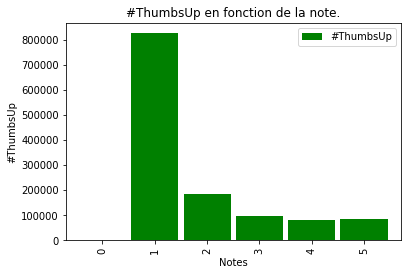

Les commentaires ayant reçu une note de 1 sont les plus souvent upvotés et de loin.


In [5]:
#Dataframe contenant la somme des thumbs up pour chaque note attribuée aux commentaires
comp_rating_thumbs_up = df.groupby("Rating").sum()
display(comp_rating_thumbs_up)

#On reset l'index car rating a été considéré comme l'index:
comp_rating_thumbs_up.reset_index().plot.bar(x="Rating", y="#ThumbsUp", width=0.9, color="g")

plt.xlabel("Notes")
plt.ylabel("#ThumbsUp")
plt.title("#ThumbsUp en fonction de la note.");
plt.show();

print("Les commentaires ayant reçu une note de 1 sont les plus souvent upvotés et de loin.")

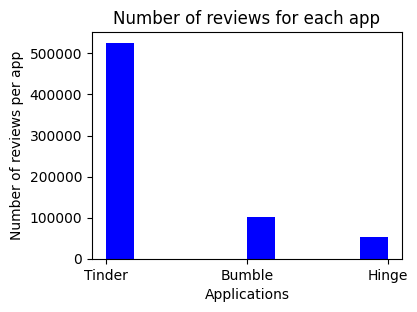

Tinder est l'application la plus notée


In [6]:
plt.figure(dpi=100, figsize=(4,3))
plt.hist(df.App, color="blue", stacked=True)
plt.xlabel("Applications")
plt.ylabel("Number of reviews per app")
plt.title("Number of reviews for each app")
plt.show();
print("Tinder est l'application la plus notée")


Rating                     
          min max      mean median
App                               
Bumble      1   5  2.832252    3.0
Hinge       1   5  3.180895    4.0
Tinder      0   5  3.007847    3.0

Hinge est l'application qui possède le la note moyenne la plus élevée. Néanmoins c'est aussi celle qui a le moins de reviews.
Avec un si petit delta dans la note moyenne associée aux apps, la note moyenne de Tinder, ayant 4 fois plus de reviews que Hinge est plus fiable.


On affiche les notes moyennes des différentes applications:


App,Bumble,Hinge,Tinder
Rating,2.832252,3.180895,3.007847


On peut voir ici que l'application la mieux notée est Hinge car sa note moyenne est 3.18/5


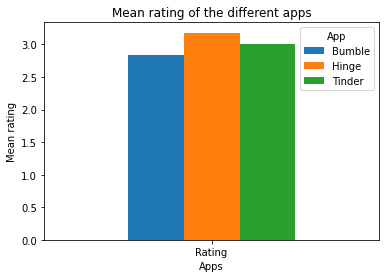

In [7]:
display(df.groupby("App").agg({"Rating": [min, max, np.mean, np.median]}))
print("Hinge est l'application qui possède le la note moyenne la plus élevée. Néanmoins c'est aussi celle qui a le moins de reviews.")
print("Avec un si petit delta dans la note moyenne associée aux apps, la note moyenne de Tinder, ayant 4 fois plus de reviews que Hinge est plus fiable.")

print("\n\nOn affiche les notes moyennes des différentes applications:")
mean_rating_df = df.groupby("App").agg({"Rating": np.mean}).T
display(mean_rating_df)

mean_rating_df.plot.bar(rot=0)

plt.title("Mean rating of the different apps")
plt.xlabel("Apps")
plt.ylabel("Mean rating")

print("On peut voir ici que l'application la mieux notée est Hinge car sa note moyenne est 3.18/5")

On regarde quelle est la répartition des notes dans le jeu de données

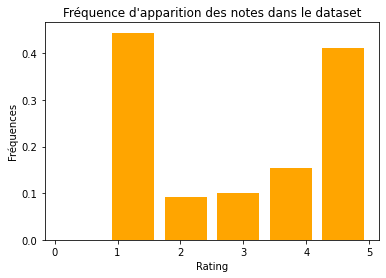

On observe une prépondérence de 1 et de 5 ce qui portent à croire que les utilisateurs sont soit très contents soit très mécontents de l'application.


In [8]:
plt.hist(df.Rating, density=True, bins=6, rwidth=0.8, color="orange")
plt.xlabel("Rating")
plt.ylabel("Fréquences")
plt.title("Fréquence d'apparition des notes dans le dataset")
plt.show();

print("On observe une prépondérence de 1 et de 5 ce qui portent à croire que les utilisateurs sont soit très contents soit très mécontents de l'application.")

### Pré-analyse du texte des reviews

#### Nombre de mots
On va analyser ici les nombres de mots de chaque review et en déduire des tendances quant à la verbosité des utilisateurs en fonction de la note associée à la review

In [9]:
#On compte les mots et on ajoute une colonne contenant ce nombre dans le dataframe initial.
df['word_count'] = df['Review'].apply(lambda x: len(str(x).split()))

print("Nombres de mots MOYENS pour les reviews ayant été notées:")
print("\t- Note 0/5:", np.round(df[df['Rating']==0]['word_count'].mean()), "mots.") #rating 0
print("\t- Note 1/5:", np.round(df[df['Rating']==1]['word_count'].mean()), "mots.") #rating 1
print("\t- Note 2/5:", np.round(df[df['Rating']==2]['word_count'].mean()), "mots.") #rating 2
print("\t- Note 3/5:", np.round(df[df['Rating']==3]['word_count'].mean()), "mots.") #rating 3
print("\t- Note 4/5:", np.round(df[df['Rating']==4]['word_count'].mean()), "mots.") #rating 4
print("\t- Note 5/5:", np.round(df[df['Rating']==5]['word_count'].mean()), "mots.") #rating 5


print("\nNombres de mots MEDIANS pour les reviews ayant été notées:")
print("\t- Note 0/5:", np.round(df[df['Rating']==0]['word_count'].median()), "mots.") #rating 0
print("\t- Note 1/5:", np.round(df[df['Rating']==1]['word_count'].median()), "mots.") #rating 1
print("\t- Note 2/5:", np.round(df[df['Rating']==2]['word_count'].median()), "mots.") #rating 2
print("\t- Note 3/5:", np.round(df[df['Rating']==3]['word_count'].median()), "mots.") #rating 3
print("\t- Note 4/5:", np.round(df[df['Rating']==4]['word_count'].median()), "mots.") #rating 4
print("\t- Note 5/5:", np.round(df[df['Rating']==5]['word_count'].median()), "mots.") #rating 5
print("Les reviews notées 4/5 et 5/5 ont une sur-représentation de reviews possédant moins de 3 mots.")


Nombres de mots MOYENS pour les reviews ayant été notées:
	- Note 0/5: 19.0 mots.
	- Note 1/5: 24.0 mots.
	- Note 2/5: 27.0 mots.
	- Note 3/5: 20.0 mots.
	- Note 4/5: 13.0 mots.
	- Note 5/5: 7.0 mots.

Nombres de mots MEDIANS pour les reviews ayant été notées:
	- Note 0/5: 19.0 mots.
	- Note 1/5: 16.0 mots.
	- Note 2/5: 20.0 mots.
	- Note 3/5: 13.0 mots.
	- Note 4/5: 7.0 mots.
	- Note 5/5: 3.0 mots.
Les reviews notées 4/5 et 5/5 ont une sur-représentation de reviews possédant moins de 3 mots.


On va représenter graphiquement ces observations:


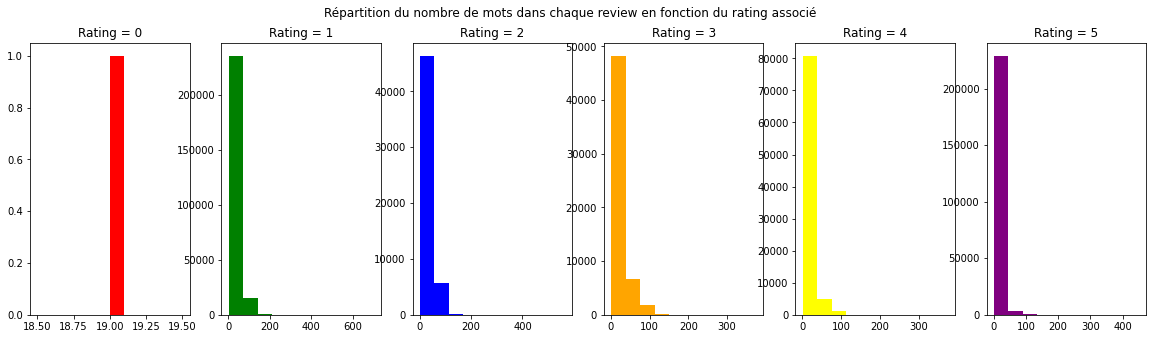

On voit ici que les moyennes du nombre de mots pour chaque review sont lourdement impactées par les commentaires qui possèdent moins de 3 mots.


In [10]:
print("On va représenter graphiquement ces observations:")

fig,(ax1,ax2, ax3, ax4, ax5, ax6)=plt.subplots(1, 6, figsize=(20,5))

train_words=df[df['Rating']==0]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Rating = 0')

train_words=df[df['Rating']==1]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Rating = 1')

train_words=df[df['Rating']==2]['word_count']
ax3.hist(train_words,color='blue')
ax3.set_title('Rating = 2')

train_words=df[df['Rating']==3]['word_count']
ax4.hist(train_words,color='orange')
ax4.set_title('Rating = 3')

train_words=df[df['Rating']==4]['word_count']
ax5.hist(train_words,color='yellow')
ax5.set_title('Rating = 4')

train_words=df[df['Rating']==5]['word_count']
ax6.hist(train_words,color='purple')
ax6.set_title('Rating = 5')

fig.suptitle("Répartition du nombre de mots dans chaque review en fonction du rating associé")
plt.show();

print("On voit ici que les moyennes du nombre de mots pour chaque review sont lourdement impactées par les commentaires qui possèdent moins de 3 mots.")


#### Statistiques sur les personnes indiquant avoir trouvé l'amour 

Nous allons maintenant analyser en fonction des mots employés, la proportion de personnes qui ont trouvé l'amour dans tous les commentaires.

In [11]:
#Utilise une regex pour définir si un commentaire contient des mots indiquant avoir trouvé l'amour et/ou une relation.
def checkLove(row):
    match = re.search(r"(met|found|married).{0,20}(husband|wife|love|partner|boyfriend|girlfriend)", row, flags=re.I)
    if match:
        return match.group(0)

In [12]:
#On crée une nouvelle ligne contenant les reviews qui sont passées sous le filtre de regex checkLove
df["found_love"] = df.Review.apply(checkLove)

#On considère comme faux positif: une review a passé le test de regex mais que la note donnée est inférieure à 4.
nb_found_love = len(df[(df.found_love.notna()) & (df.Rating >= 4)])

print("Nombre de commentaires indiquant avoir trouvé l'amour: ", nb_found_love)
print("En proportion du nombre total de commentaires, cela donne: ", np.round(nb_found_love/len(df), 4)*100, "%")

Nombre de commentaires indiquant avoir trouvé l'amour:  2210
En proportion du nombre total de commentaires, cela donne:  0.32 %


On va afficher ces observations sous forme de camembert

On voit ici que sur la totalité des commentaires, seulement 0.32% indiquent avoir trouvé l'amour sur la plateforme.


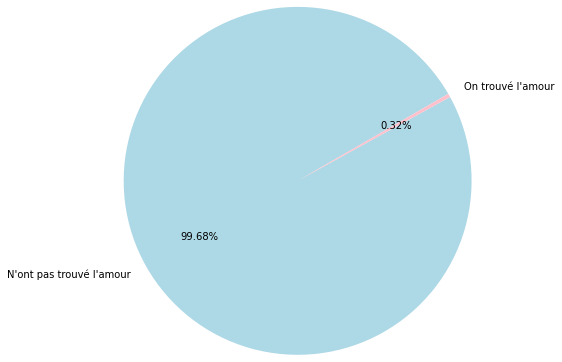

In [13]:
found_love_filter = (df.found_love.notna()) & (df.Rating >= 4)

plt.gcf().set_facecolor('white')
plt.pie(found_love_filter.value_counts(),
    labels=["N'ont pas trouvé l'amour", "On trouvé l'amour"], 
    autopct='%1.2f%%', 
    startangle=30, 
    pctdistance=0.65, 
    radius = 2, 
    colors=["lightblue", "pink"]
);

print("On voit ici que sur la totalité des commentaires, seulement 0.32% indiquent avoir trouvé l'amour sur la plateforme.")

Voyons maintenant quelle application a facilité le plus de relations amoureuses

In [14]:
display(df[(df.found_love.notna()) & (df.Rating >= 4)]\
    .groupby("App")\
    .agg({"found_love": lambda x: x.count()})
)

print("On peut voir que Tinder est l'application où le plus de personnes ont trouvé l'amour.")

,found_love
App,
Bumble,381
Hinge,174
Tinder,1655


On peut voir que Tinder est l'application où le plus de personnes ont trouvé l'amour.


### Analyse temporelle du jeu de données

Nous avons trouvé, une analyse pertinente à faire avec ce genre de jeu de données: la part de marché de chaque application en fonction des années, basée sur le nombre de review laissées, c'est ce que nous allons faire ici:

In [15]:
#On change le format de la date fourni dans le dataframe initial
df['Date&Time'] = pd.to_datetime(df['Date&Time'], format="%d-%m-%Y %H:%M")

bins=[2013, 2015, 2017, 2019, 2021, 2022]
labels=['2013-2014', '2015-2016', '2017-2018','2019-2020','2021-2022']
df_gb_year = df.groupby(by=pd.cut(df['Date&Time'].dt.year, bins=bins, labels=labels))

df_by_year = list(df_gb_year)
subplot_titles = [item[0] for item in df_by_year]

On peut voir ici que Tinder a été le premier à rentrer sur le marché mais que Bumble et Hinge on petit à petit pris des parts de marché,Bumble ayant eu l'ascension la plus importante.
Aujourd'hui Tinder reste encore l'application maîtresse avec plus de 55% de part de marché.


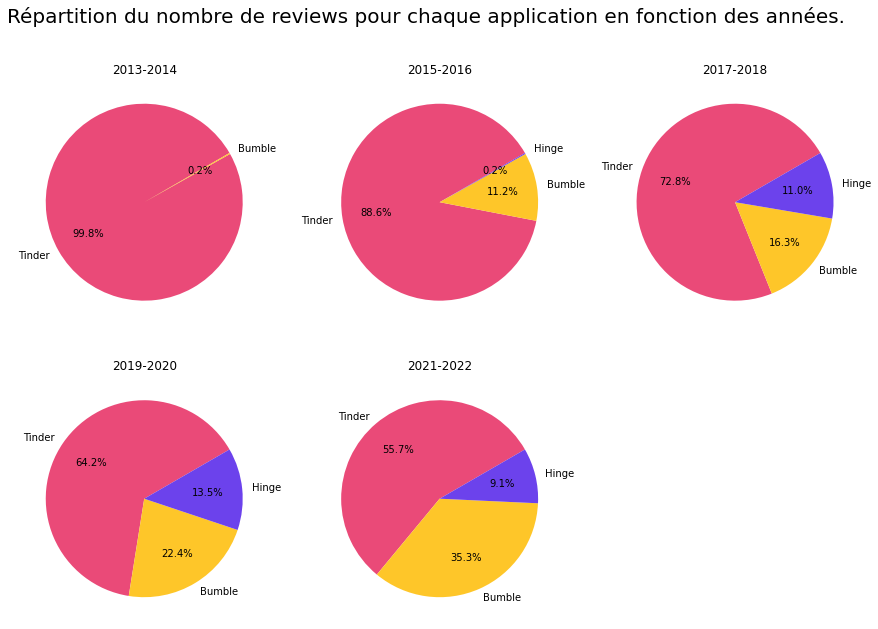

In [16]:
plt.figure(figsize=(15, 10))

#Couleurs basées sur la charte graphique des applications
colors = ['#ea4a78', '#fec629', '#6c42ec']
plt.suptitle("Répartition du nombre de reviews pour chaque application en fonction des années.", fontsize=20)

#Pour que cela soit visible sur un dark mode
plt.gcf().set_facecolor('white')

for index, item in enumerate(df_by_year):
    position = int("23" + str(index+1))
    plt.subplot(position).set_title(item[0])
    slice = item[1]['App'].value_counts().to_frame().reset_index().rename(columns={"index": "App", "App": "#Reviews"})
    plt.pie(x = slice["#Reviews"], labels=slice["App"], autopct='%1.1f%%', startangle=30, pctdistance=0.65, radius = 1, colors=colors)


print("On peut voir ici que Tinder a été le premier à rentrer sur le marché mais que Bumble et Hinge on petit à petit pris des parts de marché,\
Bumble ayant eu l'ascension la plus importante.\n\
Aujourd'hui Tinder reste encore l'application maîtresse avec plus de 55% de part de marché.")


## NLP sur les Reviews
### Pré-traitement du texte avant construction du modèle

On va ici retirer les signes de ponctuation (virgules, points etc.), les espaces/tabulations inutiles, les caractères spéciaux, les URLs, les hashtags, les stop words pour avoir du texte prêt à être analysé par notre modèle.

In [17]:
#Fonctions de preprocessing de texte

def preprocess_text(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


def remove_stopwords(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

In [18]:
#Utilisation de toutes les fonctions d'utils pour pre traiter un texte
def finalize_preprocess(string):
    return lemmatizer(remove_stopwords(preprocess_text(string)))

print("Test:")
txt = "Hi WhaT's<>*** .uP YoU &y- guys??? 😋 😋 !"
print("Preprocessing: ", txt, "\n=>", finalize_preprocess("Hi WhaT's<>*** .uP YoU &y- guys??? 😋 😋 !"))

Test:
Preprocessing:  Hi WhaT's<>*** .uP YoU &y- guys??? 😋 😋 ! 
=> hi guy


In [19]:
# On applique notre algorithme à toutes les reviews.
# /!\ C'est très long, ~1h
df['preprocessed_review'] = df['Review'].apply(lambda x: finalize_preprocess(x))

#On enregistre le dataframe dans un csv pour éviter d'avoir à le regénérer à chaque run.
df.to_csv("./processed_data.csv", sep=",")

In [20]:
#df = pd.read_csv("processed_data.csv", sep=",", index_col=0)

In [21]:
print("On remarque qu'on a ", len(df[df["preprocessed_review"].isna()])," ligne ayant un \"preprocessed_review\" == NaN, donc on peut continuer.")

On remarque qu'on a  0  ligne ayant un "preprocessed_review" == NaN, donc on peut continuer.


### Nuage de mots

L'objectif ici va être de voir si certains mots sont plus fréquemment employés que d'autres et ainsi construire un nuage de mots contenant ces observations.
Nous nous servirons de la Series preprocessed_review étant donné que nous venons de supprimer les NaNs, les stopwords et tous les mots parasites.

In [22]:
# De circonstance, on crée un masque en forme de coeur pour le wordcloud.
mask = np.array(Image.open("heart.jpg"))

wordcloud = WordCloud(background_color = 'white', max_words = 200, width=3000, height=2000, mask = mask)\
    .generate(" ".join(df["Review"]))

In [23]:
def colorize(*args, **kwargs):
    import random
    return "rgb(255, 0, {})".format(random.randint(0, 255))

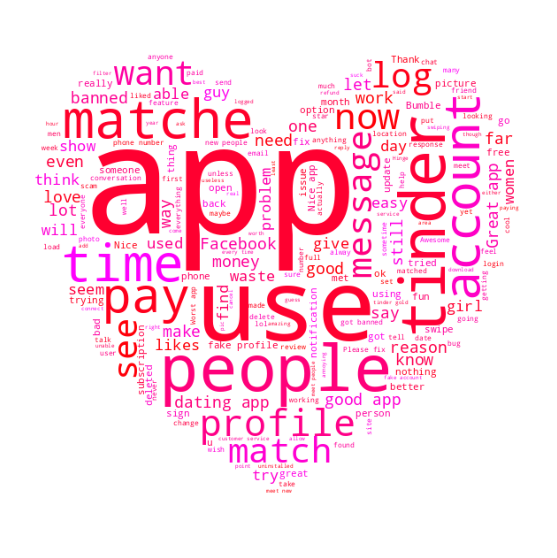

Nous avons maintenant une représentation intuitive et esthétique des mots les plus employés dans les reviews.


In [24]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func = colorize))
plt.axis("off")
plt.show();

print("Nous avons maintenant une représentation intuitive et esthétique des mots les plus employés dans les reviews.")

### Séparation des variables

On peut voir que le jeu de données est très déséquilibré, en effet les notes extrêmes (1 ou 5) représentent une grande partie des commentaires.

In [25]:
print("Pourcentage du dataset qui a un Rating de Review égal à 1 ou à 5: {}%".format(np.round((len(df[(df.Rating == 1) | (df.Rating == 5)])/len(df))*100, 2)))

print("Pourcentage du dataset qui a un Rating de Review égal à 0, 1, 2 ou 3: {}%".format(np.round((len(df[(df.Rating == 0) |(df.Rating == 1) | (df.Rating == 2) | (df.Rating == 3)])/len(df))*100, 2)))
print("Pourcentage du dataset qui a un Rating de Review égal à 4 ou 5: {}%".format(np.round((len(df[(df.Rating == 4) | (df.Rating == 5)])/len(df))*100, 2)))

print("On voit qu'en coupant le dataset en 2 avec dans la première partie les reviews ayant un rating de 0, 1, 2 ou 3 et la deuxième les ratings ayant un rating de 4 ou 5, nous avons une variable cible équilibrée à quasiment 50% - 50%")

Pourcentage du dataset qui a un Rating de Review égal à 1 ou à 5: 71.2%
Pourcentage du dataset qui a un Rating de Review égal à 0, 1, 2 ou 3: 53.03%
Pourcentage du dataset qui a un Rating de Review égal à 4 ou 5: 46.97%
On voit qu'en coupant le dataset en 2 avec dans la première partie les reviews ayant un rating de 0, 1, 2 ou 3 et la deuxième les ratings ayant un rating de 4 ou 5, nous avons une variable cible équilibrée à quasiment 50% - 50%


Nous allons donc créer une nouvelle colonne ("Sentiment") indiquant si les reviews sont plutôt positives (1) ou négatives (0).



In [26]:
# Cette fonction va remplacer les valeurs de rating par leur connotation, positive ou négative:
# Un rating égal à 0, 1, 2 ou 3 est considéré comme négatif
# Un rating égal a 4 ou 5 est considéré comme positif.  

def replace_rating(rating):
    if rating == 4 or rating == 5:
        return 1
    else:
        return 0

In [27]:
df["Sentiment"] = df["Rating"].apply(lambda rating: replace_rating(rating))

In [28]:
df.Sentiment.value_counts()

0    360930
1    319712
Name: Sentiment, dtype: int64

On sépare ici le jeu de données en 2 afin d'extraire les variables explicatives de la variable cible. 

Notre variable explicative est ici "Review" et la variable cible est "Sentiment"

In [29]:
print("On est surtout intéressés par les Reviews et le sentiment associé donc on drop les colonnes qui ne nous servent pas.")

X = df["preprocessed_review"]
y = df["Sentiment"]

On est surtout intéressés par les Reviews et le sentiment associé donc on drop les colonnes qui ne nous servent pas.


### Vectorisation du texte

Dans cette partie nous allons vectoriser les mots de la colonne `preprocessed_review` c'est à dire convertir les données textuelles en données/vecteurs numériques.
Nous allons utiliser une variante de la méthode Bag of Words avec du word embedding (en utilisant Word2Vec). Cela va permettre de comprendre le contexte dans lequel chaque mot a été employé au lieu d'analyser un mot isolément. Les données numériques calculées le seront à l'aide de l'approche TF-IDF, permettant d'apporter une dimension statistique correspondant à la probabilité de trouver un mot dans les reviews: un mot qui est souvent utilisé est plus important et un mot qui est rare l'est tout autant.

In [30]:
# On sépare les jeux de données en set de test et d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [31]:
#Word2Vec
# Word2Vec se base sur des phrases tokenisées donc on tokenise:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [32]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [33]:
#Construction du modèle Word2Vec
class MeanEmbeddingVectorizer(object):
        def __init__(self, word2vec):
                self.word2vec = word2vec
                self.dim = len(next(iter(word2vec.values())))

        def fit(self, X, y):
                return self

        def transform(self, X):
                return np.array([
                        np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
                ])

df['preprocessed_review_tok'] = [nltk.word_tokenize(i) for i in df['preprocessed_review']]

model = Word2Vec(df['preprocessed_review_tok'], min_count=1)    
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [34]:
# On convertit le texte en données numériques avec Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

### Entraînement et choix des algorithmes de machine learning sur le jeu de données

Dans cette partie nous allons essayer de trouver le modèle qui nous permet d'avoir la plus haute accuracy possible.

Nous essaierons les modèles suivants de scikit learn:
1. LogisticRegression
2. DecisionTreeClassifier
3. Multinomial Naive Bayes (MultinomialNB)
4. SGDClassifier

#### 1. LogisticRegression

In [35]:
log_reg = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
log_reg.fit(X_train_vectors_tfidf, y_train)

#On prédit y pour le dataset de test
y_test_predict_log_reg = log_reg.predict(X_test_vectors_tfidf)

#On prédit y pour le dataset d'entraînement
y_train_predict_log_reg = log_reg.predict(X_train_vectors_tfidf)

print("LogisticRegression classification report:")
print(classification_report(y_test, y_test_predict_log_reg, zero_division=1))


LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     72265
           1       0.87      0.86      0.87     63864

    accuracy                           0.88    136129
   macro avg       0.87      0.87      0.87    136129
weighted avg       0.88      0.88      0.88    136129



#### 2. DecisionTreeClassifier

In [36]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train_vectors_tfidf, y_train)

#On prédit y pour le dataset de test
y_test_predict_dec_tree = dec_tree.predict(X_test_vectors_tfidf)

#On prédit y pour le dataset d'entraînement
y_train_predict_dec_tree = dec_tree.predict(X_train_vectors_tfidf)

print("DecisionTreeClassifier classification report:")
print(classification_report(y_test, y_test_predict_dec_tree, zero_division=1))

DecisionTreeClassifier classification report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     72265
           1       0.82      0.83      0.82     63864

    accuracy                           0.83    136129
   macro avg       0.83      0.83      0.83    136129
weighted avg       0.83      0.83      0.83    136129



#### 3. MultinomialNB

In [37]:
multi_nb = MultinomialNB(fit_prior=False)
multi_nb.fit(X_train_vectors_tfidf, y_train)

#On prédit y pour le dataset de test
y_test_predict_multi_nb = multi_nb.predict(X_test_vectors_tfidf)

#On prédit y pour le dataset d'entraînement
y_train_predict_multi_nb = multi_nb.predict(X_train_vectors_tfidf)

print("MultinomialNB classification report:")
print(classification_report(y_test, y_test_predict_multi_nb, zero_division=1))

MultinomialNB classification report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     72265
           1       0.88      0.80      0.84     63864

    accuracy                           0.86    136129
   macro avg       0.86      0.85      0.85    136129
weighted avg       0.86      0.86      0.85    136129



#### 4. SGDClassifier

In [38]:
sgdc = SGDClassifier()
sgdc.fit(X_train_vectors_tfidf, y_train)

#On prédit y pour le dataset de test
y_test_predict_sgdc = sgdc.predict(X_test_vectors_tfidf)

#On prédit y pour le dataset d'entraînement
y_train_predict_sgdc = sgdc.predict(X_train_vectors_tfidf)

print("SGDClassifier classification report:")
print(classification_report(y_test, y_test_predict_sgdc, zero_division=1))

SGDClassifier classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     72265
           1       0.86      0.86      0.86     63864

    accuracy                           0.87    136129
   macro avg       0.87      0.87      0.87    136129
weighted avg       0.87      0.87      0.87    136129



Après avoir essayé un certain nombre de modèles de classification et après avoir comparé les accuracies, choisissons celui qui a le meilleur score sur le jeu de données de test tout en ayant une accuracy cohérente sur le jeu de données d'entrainement. Une accuracy trop haute indiquerait un surappretissage:

In [39]:
print("Comparaison des accuracies:")

print("\nLogisticRegression")
print("Test: ", accuracy_score(y_test, y_test_predict_log_reg))
print("Train:", accuracy_score(y_train, y_train_predict_log_reg))

print("\nDecisionTreeClassifier")
print("Test: ", accuracy_score(y_test, y_test_predict_dec_tree))
print("Train:", accuracy_score(y_train, y_train_predict_dec_tree))

print("\nMultinomialNB")
print("Test: ", accuracy_score(y_test, y_test_predict_multi_nb))
print("Train:", accuracy_score(y_train, y_train_predict_multi_nb))

print("\nSGDClassifier")
print("Test: ", accuracy_score(y_test, y_test_predict_sgdc))
print("Train:", accuracy_score(y_train, y_train_predict_sgdc))

Comparaison des accuracies:

LogisticRegression
Test:  0.875360870938595
Train: 0.8949648585065921

DecisionTreeClassifier
Test:  0.8334080173952648
Train: 0.9695691379269182

MultinomialNB
Test:  0.8555193970425111
Train: 0.8670628616763971

SGDClassifier
Test:  0.8704831446642523
Train: 0.8699002594979367


Nous choissisons donc la **regression logistique** qui semble avoir des résultats satisfaisants.

In [40]:
#Test sur des phrases négatives et positives
text1 = "the app is bad"
text2 = "It's a nice app, I'll keep using it until I find love"

print('"', text1, '"', "\n=> prédiction de sentiment: ", log_reg.predict(tfidf_vectorizer.transform([text1])))
print("\n")
print('"', text2, '"', "\n=> prédiction de sentiment: ", log_reg.predict(tfidf_vectorizer.transform([text2])))

" the app is bad " 
=> prédiction de sentiment:  [0]


" It's a nice app, I'll keep using it until I find love " 
=> prédiction de sentiment:  [1]


## Sauvegarde des données pour utilisation dans une API

Ici on utilise la librairie joblib pour sauvegarder les modèles ainsi que leurs performances afin de les charger dans notre API que nous développerons par la suite.

In [41]:
import joblib

joblib.dump(log_reg, "log_reg_model.sav")
joblib.dump(dec_tree, "dec_tree_model.sav")
joblib.dump(multi_nb, "multi_nb_model.sav")
joblib.dump(sgdc, "sgdc_model.sav")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.sav");

In [42]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

In [43]:
log_reg_performances = {
    "f1_score":  f1_score(y_test, y_test_predict_log_reg),
    "accuracy_score": accuracy_score(y_test, y_test_predict_log_reg),
    "recall_score":  recall_score(y_test, y_test_predict_log_reg),
    "precision_score":  precision_score(y_test, y_test_predict_log_reg)
}

In [44]:
dec_tree_performances = {
    "f1_score":  f1_score(y_test, y_test_predict_dec_tree),
    "accuracy_score": accuracy_score(y_test, y_test_predict_dec_tree),
    "recall_score":  recall_score(y_test, y_test_predict_dec_tree),
    "precision_score":  precision_score(y_test, y_test_predict_dec_tree)
}

In [45]:
multi_nb_performances = {
    "f1_score":  f1_score(y_test, y_test_predict_multi_nb),
    "accuracy_score": accuracy_score(y_test, y_test_predict_multi_nb),
    "recall_score":  recall_score(y_test, y_test_predict_multi_nb),
    "precision_score":  precision_score(y_test, y_test_predict_multi_nb)
}

In [46]:
sgdc_performances = {
    "f1_score":  f1_score(y_test, y_test_predict_sgdc),
    "accuracy_score": accuracy_score(y_test, y_test_predict_sgdc),
    "recall_score":  recall_score(y_test, y_test_predict_sgdc),
    "precision_score":  precision_score(y_test, y_test_predict_sgdc)
}

In [47]:
joblib.dump(log_reg_performances, "log_reg_performances.sav")
joblib.dump(dec_tree_performances, "dec_tree_performances.sav")
joblib.dump(multi_nb_performances, "multi_nb_performances.sav")
joblib.dump(sgdc_performances, "sgdc_performances.sav");
